## Imports Configuration

In [9]:
import numpy as np
import random
import mnist_loader
import collections
import scipy
from scipy import ndimage, misc
import matplotlib.pyplot as plt
import gzip
import sys

try:
   import cPickle as cPickle
except:
   import pickle as cPickle

## Download the data set

Run the following cell to download the [MNIST dataset for python](http://deeplearning.net/data/mnist/mnist.pkl.gz).

In [38]:
"""
RUN THIS CELL TO DOWNLOAD THE MNIST DATA SET
"""
from urllib.request import urlretrieve
from os import access, path, R_OK
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile
import gzip
import glob

FILE_NAME = 'mnist.pkl.gz'
FILE_PATH = './data'
FILE_REMOTE_URL = 'http://deeplearning.net/data/mnist/mnist.pkl.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(FILE_NAME):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='MNIST Dataset') as pbar:
        urlretrieve(FILE_REMOTE_URL ,FILE_NAME, pbar.hook)
        
if not isdir(FILE_NAME):
    with gzip.open(FILE_NAME, 'rb') as in_file:
        s = in_file.read()

    # Now store the uncompressed data
    FILE_TO_STORE = FILE_NAME[:-3]  # remove the '.gz' from the filename
    # store uncompressed file data from 's' variable
    with open(FILE_TO_STORE, 'wb') as f:
        f.write(s)
else:
    print ("Either file is missing or is not readable")
        

## Understanding Our Dataset

Our dataset consists of a se of training, validation and test data in `(x,y)` i.e `(digit_image, digit_label)`. For example:
```python
digit_image = training_data[0][index]
digit_label = training_data[1][index]
```

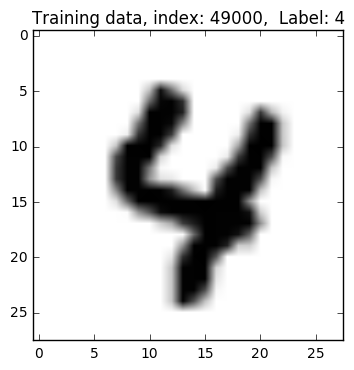


Stats of batch 1:
Samples: 50000
Label Counts: {0.0: 31696720, 0.00390625: 19056, 0.85546875: 16299, 0.5546875: 14938, 0.2890625: 11546, 0.70703125: 14347, 0.015625: 31730, 0.01171875: 29886, 0.8359375: 21363, 0.16796875: 17750, 0.046875: 25090, 0.95703125: 29403, 0.26171875: 13220, 0.671875: 15407, 0.5078125: 14875, 0.1875: 16719, 0.921875: 26368, 0.11328125: 30710, 0.18359375: 20356, 0.66015625: 21329, 0.3046875: 14693, 0.5859375: 14173, 0.43359375: 13341, 0.875: 20083, 0.984375: 552647, 0.92578125: 24815, 0.91015625: 30616, 0.0625: 24314, 0.21484375: 15062, 0.76171875: 16616, 0.19140625: 14801, 0.6875: 14449, 0.61328125: 12224, 0.5390625: 14499, 0.0703125: 22279, 0.359375: 15446, 0.96484375: 31544, 0.390625: 12674, 0.19921875: 20705, 0.31640625: 13711, 0.86328125: 20632, 0.7890625: 16254, 0.078125: 24802, 0.71484375: 16531, 0.09375: 21544, 0.640625: 12877, 0.20703125: 16002, 0.56640625: 15200, 0.4921875: 14062, 0.41796875: 13656, 0.3359375: 21235, 0.90625: 25212, 0.34375: 13109, 0.

NameError: name '_load_label_names' is not defined

In [15]:
def display_stats(training_data, sample_id):
    """
    Display Stats of the the dataset
    """

    print('\nStats of batch {}:'.format(1))
    print('Samples: {}'.format(len(training_data[0])))
    print('Label Counts: {}'.format(dict(zip(*np.unique(training_data[0], return_counts=True)))))
    print('First 20 Labels: {}'.format(training_data[1][:20]))

    sample_image = training_data[0][sample_id]
    sample_label = training_data[1][sample_id]
    label_names = _load_label_names()

    print('\nExample of Image {}:'.format(1))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    #print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    plt.axis('off')
    plt.imshow(sample_image)
# Function to unwrap our data set into training, validation and testing data
def unpickle(file):
    fo = open(file, 'rb')
    dict = cPickle.load(fo,encoding='latin1')
    fo.close()
    return list(dict)

# Function for displaying a training image by it's index in the MNIST set
def display_image(training_data, index):
    digit_label = training_data[1][index]
    # Reshape 784 array into 28x28 image
    digit_image = training_data[0][index].reshape([28,28])

    plt.title('Training data, index: %d,  Label: %d' % (index, digit_label))
    plt.imshow(digit_image, cmap='gray_r')
    plt.show()

# Retrieve the training, validation and test data
training_data, validation_data, test_data = unpickle("mnist.pkl")
display_image(training_data, 49000)
display_stats(training_data, 300)

In [99]:
class Network(object):

    def __init__(self, sizes):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]
    def printValues(self):
        print(self.weights)
        print(self.biases)
    
    def feedforward(self, a):
        #Return the output of the network if "a" is input.
        for b, w in zip(self.biases, self.weights):
            a = self.sigmoid(np.dot(w, a)+b)
        return a
    
    def SGD(self, training_data, epochs, mini_batch_size, learning_rate, test_data=None):
        #Train the neural network using mini-batch stochastic gradient descent.  The "training_data" is a list of tuples
        #"(x, y)" representing the (training inputs, desired outputs).  The other non-optional parameters are self-explanatory.
        if test_data: 
            #Get the size of the test data
            test_data_size = len(test_data)
        #Get size of the training data
        training_data_size = len(training_data)
        #Iterate training over all epochs
        for j in range(epochs):
            #Shuffle the Training Data
            random.shuffle(training_data)
            #Partition it into mini-batches of the appropriate size
            mini_batches = [training_data[k:k+mini_batch_size] for k in range(0, training_data_size, mini_batch_size)]
            #For each mini_batch apply a single step of gradient descent
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, learning_rate)
            #If "test_data" is provided then the network will be evaluated against the test data after each epoch
            if test_data:
                #Print the partial progress which is useful for tracking progress, but slows things down substantially
                accuracy = self.evaluate(test_data)/test_data_size
                print ("Epoch {0} Accuracy: {1}".format(j, accuracy))
            else:
                print ("Epoch {0} Complete".format(j))
                
    def update_mini_batch(self, mini_batch, learning_rate):
        #Update the network's weights and biases by applying gradient descent using backpropagation to a single mini batch.
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        #The "mini_batch" is a list of tuples "(x, y). Compute gradients for every training sample in the mini_batch
        for x, y in mini_batch:
            x= np.reshape(x, (784, 1))
            #Do the back propagation
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        #Update the self.weights and self.biases appropriately.
        self.weights = [w-(learning_rate/len(mini_batch))*nw for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(learning_rate/len(mini_batch))*nb for b, nb in zip(self.biases, nabla_b)]
        
    def backprop(self, x, y):
        #Return a tuple ``(nabla_b, nabla_w)`` representing the gradient for the cost function C_x.  ``nabla_b`` and
        #``nabla_w`` are layer-by-layer lists of numpy arrays, similar to ``self.biases`` and ``self.weights``.
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = self.sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * self.sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = self.sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)
    
    def evaluate(self, test_data):
        # Return the number of test inputs for which the neural network outputs the correct result. Note that the neural
        # network's output is assumed to be the index of whichever neuron in the final layer has the highest activation.
        test_results = [(np.argmax(self.feedforward(x.reshape((784, 1)))), y) for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y)

    #### Miscellaneous functions
    def sigmoid(self,z):
        """The sigmoid function."""
        return 1.0/(1.0+np.exp(-z))

    def sigmoid_prime(self,z):
        """Derivative of the sigmoid function."""
        return self.sigmoid(z)*(1-self.sigmoid(z))

net = Network([784, 100, 10])
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()
training_input = training_data
test_input = test_data
net.SGD(training_input, 30, 20, 3, test_data=test_input)
#net.printValues()

Epoch 0 Accuracy: 0.5809
Epoch 1 Accuracy: 0.6798
Epoch 2 Accuracy: 0.7719
Epoch 3 Accuracy: 0.7796
Epoch 4 Accuracy: 0.8527
Epoch 5 Accuracy: 0.8642
Epoch 6 Accuracy: 0.8805
Epoch 7 Accuracy: 0.943
Epoch 8 Accuracy: 0.9487
Epoch 9 Accuracy: 0.9523
Epoch 10 Accuracy: 0.9546
Epoch 11 Accuracy: 0.9555
Epoch 12 Accuracy: 0.9532
Epoch 13 Accuracy: 0.9544
Epoch 14 Accuracy: 0.9587
Epoch 15 Accuracy: 0.9602
Epoch 16 Accuracy: 0.958
Epoch 17 Accuracy: 0.9593
Epoch 18 Accuracy: 0.9598
Epoch 19 Accuracy: 0.9598
Epoch 20 Accuracy: 0.9614
Epoch 21 Accuracy: 0.9604
Epoch 22 Accuracy: 0.9609
Epoch 23 Accuracy: 0.9598
Epoch 24 Accuracy: 0.9604
Epoch 25 Accuracy: 0.9608
Epoch 26 Accuracy: 0.961
Epoch 27 Accuracy: 0.9616
Epoch 28 Accuracy: 0.9609
Epoch 29 Accuracy: 0.9611
